In [15]:
%matplotlib widget
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt

from map_environment import MapEnvironment, Point2D, create_sample_map
from pathfinding import find_grid_path
from vehicle import Vehicle
from visibility import compute_path_visibility, compute_visibility_polygon
from visualization import (
    animate_vehicle,
    plot_all_visibility,
    plot_grid,
    plot_map,
    plot_path,
    plot_visibility,
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Step 1 -- Create the Map with Obstacles

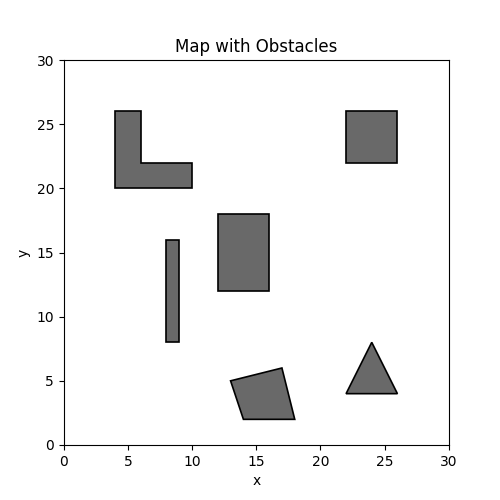

In [16]:
map_env: MapEnvironment = create_sample_map()

fig, ax = plt.subplots(figsize=(5, 5))
plot_map(ax, map_env)
plt.show()

## Step 2 -- Grid Overlay

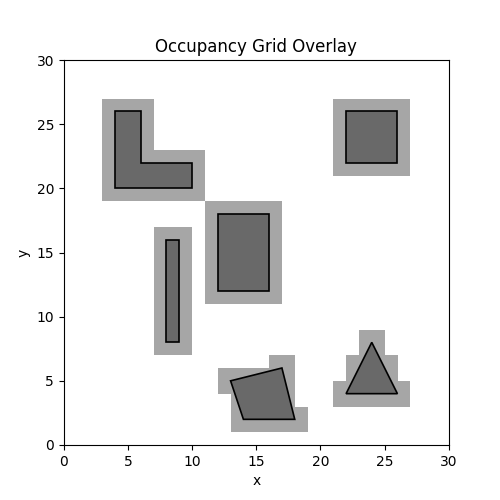

In [17]:
fig, ax = plt.subplots(figsize=(5, 5))
plot_map(ax, map_env)
plot_grid(ax, map_env)
plt.show()

## Step 3 -- A* Pathfinding

Path found with 34 waypoints.


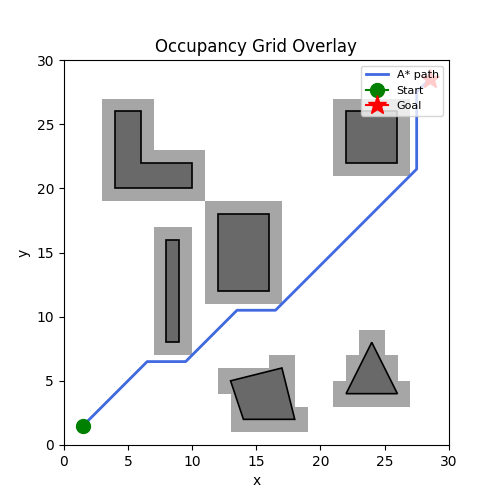

In [18]:
start: Point2D = Point2D(1.0, 1.0)
goal: Point2D = Point2D(28.0, 28.0)

path: list[Point2D] | None = find_grid_path(map_env, start, goal)

if path is None:
    print("No path found!")
else:
    print(f"Path found with {len(path)} waypoints.")

    fig, ax = plt.subplots(figsize=(5, 5))
    plot_map(ax, map_env)
    plot_grid(ax, map_env)
    plot_path(ax, path)
    plt.show()

## Step 4 -- Visibility at Key Waypoints

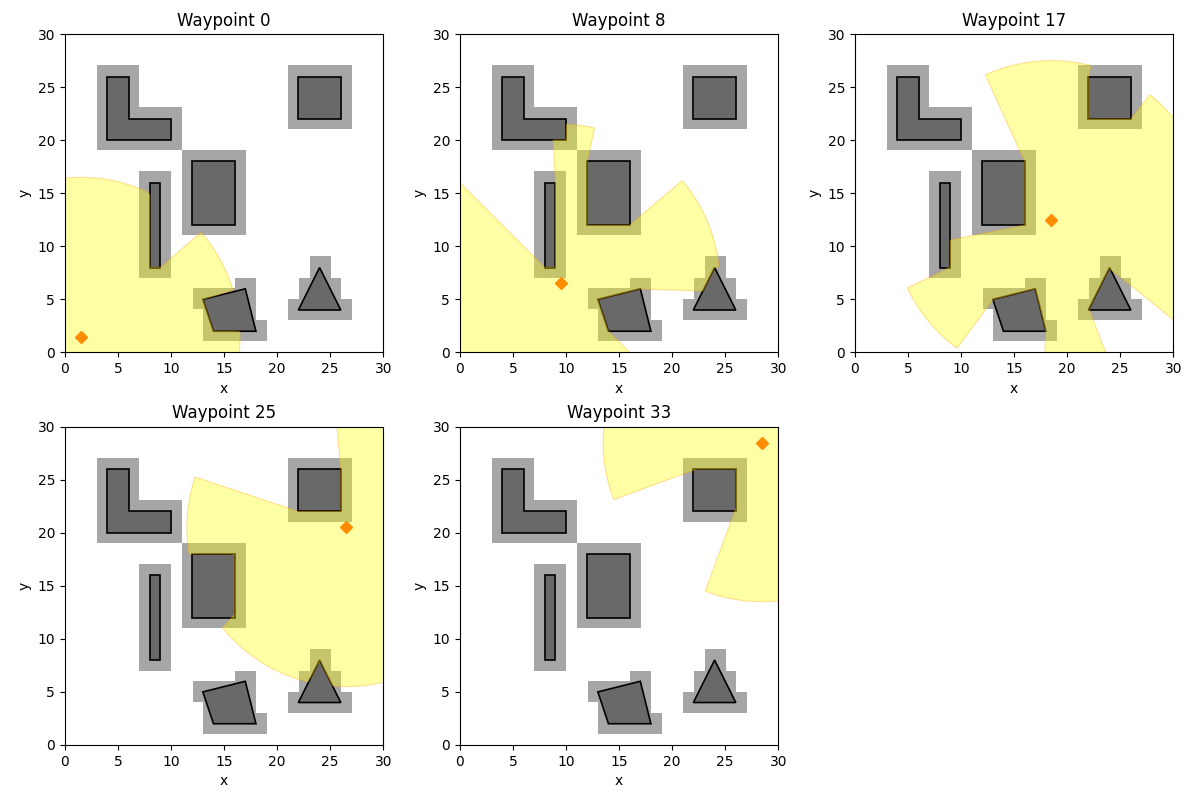

In [19]:
assert path is not None, "Path must exist for visibility computation."

# Pick a few representative waypoints: start, 1/4, 1/2, 3/4, end
indices: list[int] = [
    0,
    len(path) // 4,
    len(path) // 2,
    3 * len(path) // 4,
    len(path) - 1,
]
max_radius: float = 15.0

n_plots: int = len(indices)
n_cols: int = 3
n_rows: int = (n_plots + n_cols - 1) // n_cols  # ceil division

fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 4 * n_rows))
flat_axes = axes.flatten()

for i, idx in enumerate(indices):
    ax = flat_axes[i]
    observer: Point2D = path[idx]
    vis_poly = compute_visibility_polygon(observer, map_env.obstacles, max_radius)

    plot_map(ax, map_env)
    plot_grid(ax, map_env)
    plot_visibility(ax, observer, vis_poly)
    ax.set_title(f"Waypoint {idx}")

# Hide any unused subplot slots
for j in range(n_plots, len(flat_axes)):
    flat_axes[j].set_visible(False)

plt.tight_layout()
plt.show()

## Step 5 -- Combined Visibility along the Entire Path

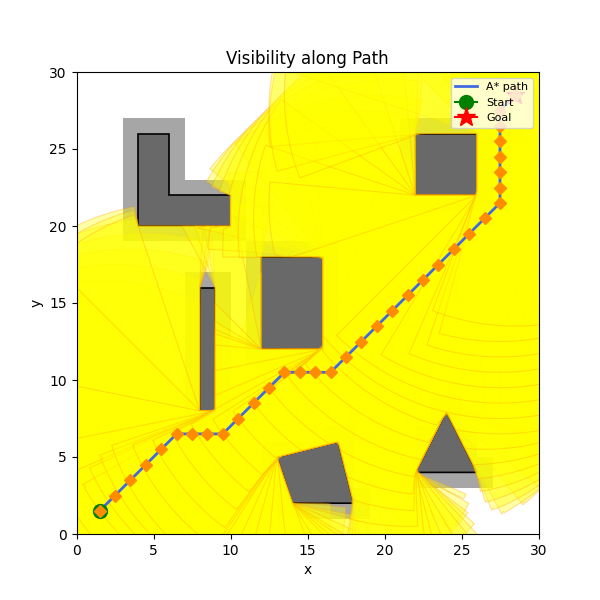

In [20]:
visibility_polygons: list = compute_path_visibility(
    path, map_env.obstacles, max_radius
)

fig, ax = plt.subplots(figsize=(6, 6))
plot_map(ax, map_env)
plot_grid(ax, map_env)
plot_all_visibility(ax, path, visibility_polygons)
plot_path(ax, path)
plt.show()

## Step 6 -- Animated Vehicle Traversal with Path Prediction

A `Vehicle` moves along the A* path at a specified speed.  The animation shows:
- **Orange dot / line** -- current vehicle position and heading.
- **Green dashed line / dots** -- predicted positions over the next few seconds.
- **Yellow region** -- real-time visibility polygon.

Path length : 41.7 units
Vehicle speed: 2.0 units/s
Travel time  : 20.8 s


C:\Users\jtomczak\AppData\Local\Temp\ipykernel_31176\201992660.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(6, 6))


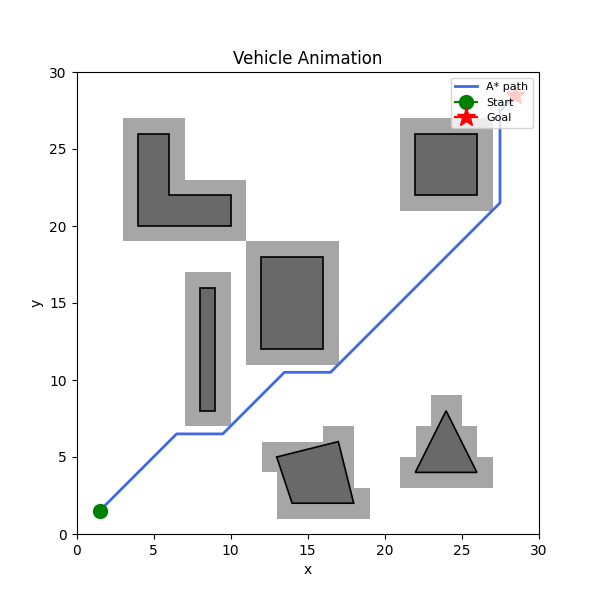

In [24]:
assert path is not None, "Path must exist for animation."

# Create a vehicle that moves at 2 units/second.
vehicle: Vehicle = Vehicle(path, speed=2.0)
print(f"Path length : {vehicle.total_length:.1f} units")
print(f"Vehicle speed: {vehicle.speed} units/s")
print(f"Travel time  : {vehicle.total_time:.1f} s")

fig, ax = plt.subplots(figsize=(6, 6))

anim = animate_vehicle(
    fig,
    ax,
    map_env,
    vehicle,
    max_vis_radius=max_radius,
    prediction_horizon=3.0,  # predict 3 seconds into the future
    prediction_samples=8,    # 8 sample dots along the prediction
    dt=0.15,                 # simulation timestep per frame
    interval_ms=60,          # milliseconds between frames
)

plt.show()